## Introduction

### Problem Statement

- Forecasting cryptocurrency prices, particularly Bitcoin, is a challenging yet valuable task due to the asset’s high volatility and market sensitivity. Investors, analysts, and trading platforms rely on timely insights to make informed decisions. The problem this project addresses is: how can we build a reliable, real-time forecasting system that predicts short-term Bitcoin price movements using both historical and live data? 
- By leveraging Facebook Prophet, a time series forecasting tool, the project aims to process noisy and irregular financial data, model seasonality and trends, and produce accurate, interpretable forecasts. The solution must also be robust to missing data, flexible for customization, and scalable enough for real-time applications.


## **DATA INGESTION**

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [2]:
from utils import (load_historical_data,fetch_live_data,merge_and_clean_data,create_prophet_model,
                             train_prophet_model,make_forecast,plot_forecast)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
%matplotlib inline
import seaborn as sns
import requests
import warnings
import scipy.stats as stats
from scipy.stats import normaltest,zscore
warnings.filterwarnings('ignore')

In [4]:
# Load historical Bitcoin data
historical_btc_df = load_historical_data('../data/bitcoin_historical_data.csv')
historical_btc_df.head()

,ds,y
0,2012-01-01,4.84
1,2012-01-02,5.00
2,2012-01-03,5.29
3,2012-01-04,5.57
4,2012-01-05,6.42


In [5]:
# Fetch live Bitcoin prices from API
live_btc_df = fetch_live_data(days=365, currency='usd')
live_btc_df.head()

,ds,y
0,2024-05-05,63820.451903
1,2024-05-06,64010.008652
2,2024-05-07,63172.481296
3,2024-05-08,62363.057192
4,2024-05-09,61215.504009


In [6]:
# Merge historical and live data
bitcoin_data_df = merge_and_clean_data(historical_btc_df, live_btc_df)
bitcoin_data_df.head()

,ds,y
0,2012-01-01,4.84
1,2012-01-02,5.00
2,2012-01-03,5.29
3,2012-01-04,5.57
4,2012-01-05,6.42


In [7]:
bitcoin_data_df.shape

(4873, 2)

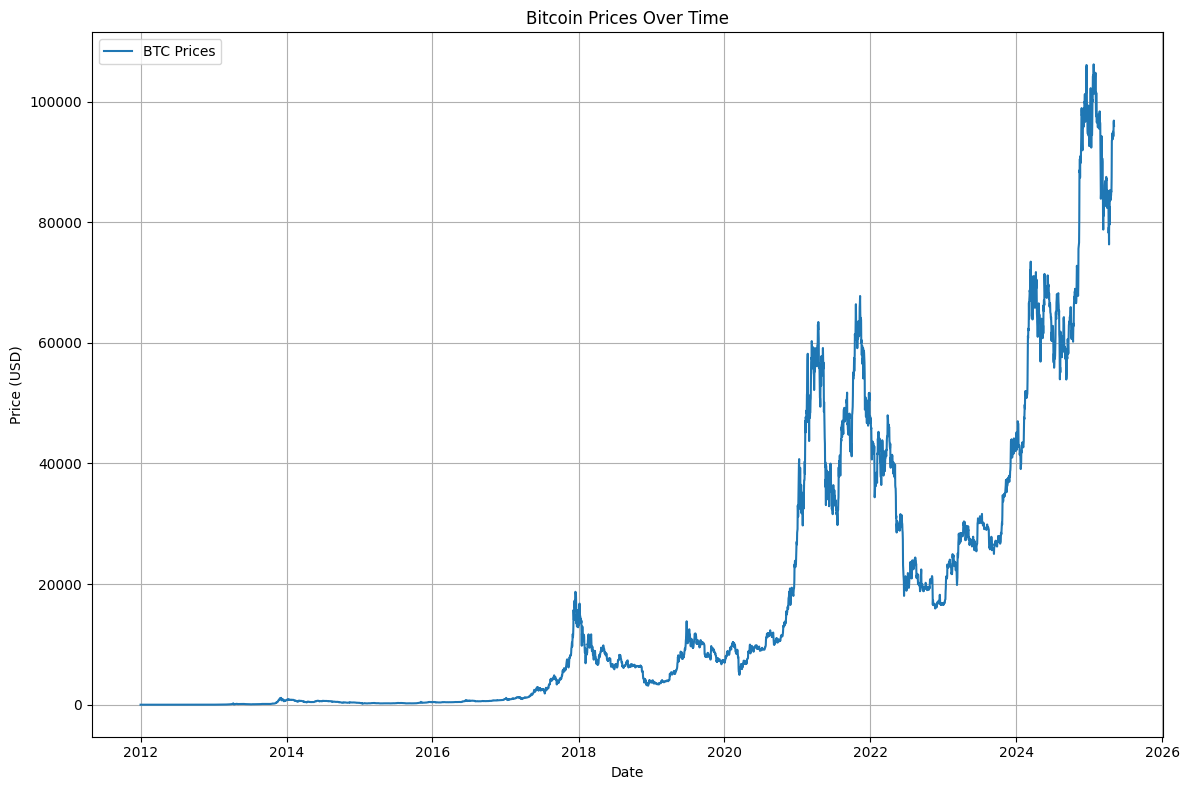

In [8]:
plt.figure(figsize=(12,8))
plt.plot(bitcoin_data_df['ds'], bitcoin_data_df['y'], label='BTC Prices')
plt.title('Bitcoin Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()  
plt.tight_layout()
plt.show()

## **EXPLORATORY DATA ANALYSIS**

### Dataset Overview

In [9]:
# Time range
print("Start Date:", bitcoin_data_df['ds'].min())
print("End Date:", bitcoin_data_df['ds'].max())
bitcoin_data_df.sort_values('ds',inplace=True)

Start Date: 2012-01-01 00:00:00
End Date: 2025-05-04 00:00:00


In [10]:
# Total records 
print("total Daily records:",len(bitcoin_data_df))

total Daily records: 4873


In [11]:
print('Statistics Summary of our Dataset:')
bitcoin_data_df.describe()

Statistics Summary of our Dataset:


,ds,y
count,4873,4873.000000
mean,2018-09-02 00:00:00,17464.171974
min,2012-01-01 00:00:00,4.380000
25%,2015-05-03 00:00:00,424.690000
50%,2018-09-02 00:00:00,6619.310000
75%,2022-01-02 00:00:00,27375.000000
max,2025-05-04 00:00:00,106182.236820
std,NaN,24139.702192


This dataset contains 4,869 daily Bitcoin price records from January 1, 2012, to April 30, 2025, with no missing entries or duplicate dates, indicating a complete and continuous time series. The prices range from a minimum of 4.38 dollars to a maximum of 106,182.24 dollars, with an average of approximately 17,399.56 dollars and a median of 6,603.82 dollars, suggesting a right-skewed distribution due to sharp price increases in recent years. The standard deviation of 24,044.35 dollars reflects substantial volatility, and the wide range between the 25th percentile (424.45 dollars) and the 75th percentile (27,267.00 dollars) indicates the presence of significant outliers. These outliers, often driven by speculative surges, are crucial to consider when building reliable forecasting models like Facebook Prophet.


### DATA QUALITY CHECKS

In [12]:
print("The number of missing entries:")
bitcoin_data_df.isnull().sum()

The number of missing entries:


ds    0
y     0
dtype: int64

In [13]:
# Check for missing days (gap in timeline)
expected_dates = pd.date_range(start=bitcoin_data_df['ds'].min(), end=bitcoin_data_df['ds'].max(), freq='D')
actual_dates = pd.to_datetime(bitcoin_data_df['ds'])
missing_days = expected_dates.difference(actual_dates)
print(f"\nNumber of missing days: {len(missing_days)}")
if len(missing_days) > 0:
    print("Missing dates:", missing_days[:5])


Number of missing days: 0


We verified that the dataset has no missing values in either the ds (date) or y (price) columns, and there are no missing days in the time series. This confirms that the data is clean, complete, and continuous which is ideal for Facebook Prophet, as it relies on regular daily intervals to accurately model trends and seasonality.

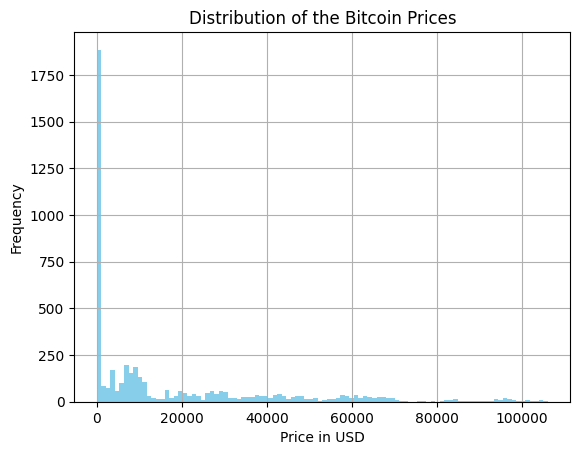

In [14]:
# understanding distribution of the data
plt.hist(bitcoin_data_df['y'],bins=100,color='skyblue')
plt.title('Distribution of the Bitcoin Prices')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.grid(True)

The distribution of Bitcoin prices is highly right-skewed, with most prices concentrated in the lower range (under 10,000 dollars). A sharp peak is observed at low price levels, while higher prices (above 20,000 dollars) occur less frequently but stretch out over a long tail up to 100,000+ dollars. This confirms the presence of extreme outliers and exponential growth over time.

Text(0.5, 1.0, 'QQ Plot for the bitcoin Prices')

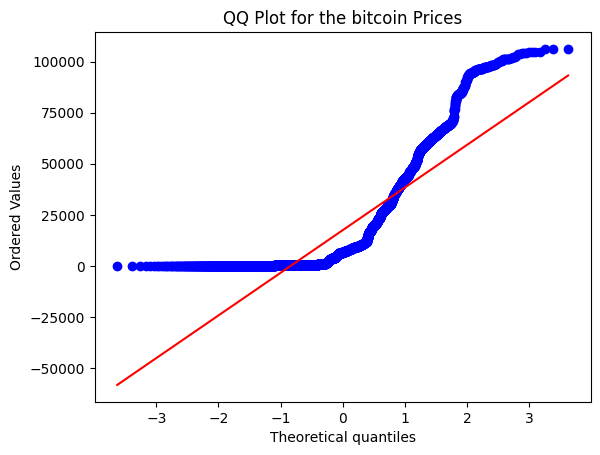

In [15]:
stats.probplot(bitcoin_data_df['y'], dist="norm",plot=plt)
plt.title("QQ Plot for the bitcoin Prices")

The QQ plot shows that Bitcoin prices are not normally distributed, displaying a heavy right skew and extreme outliers. This is typical for financial time series data and supports the use of models like Facebook Prophet, which do not assume normality and can handle irregular patterns effectively.

In [16]:
# Checking the number of potential outliers
from scipy.stats import zscore
z_score=zscore(bitcoin_data_df['y'])
outliers= bitcoin_data_df[z_score>3]
print(f'\nThe number of potential outliers:{len(outliers)}')
print(outliers[['ds','y']].head())


The number of potential outliers:117
             ds             y
4701 2024-11-14  90488.100075
4703 2024-11-16  90947.975094
4704 2024-11-17  90606.454894
4706 2024-11-19  90534.624597
4707 2024-11-20  92251.652407


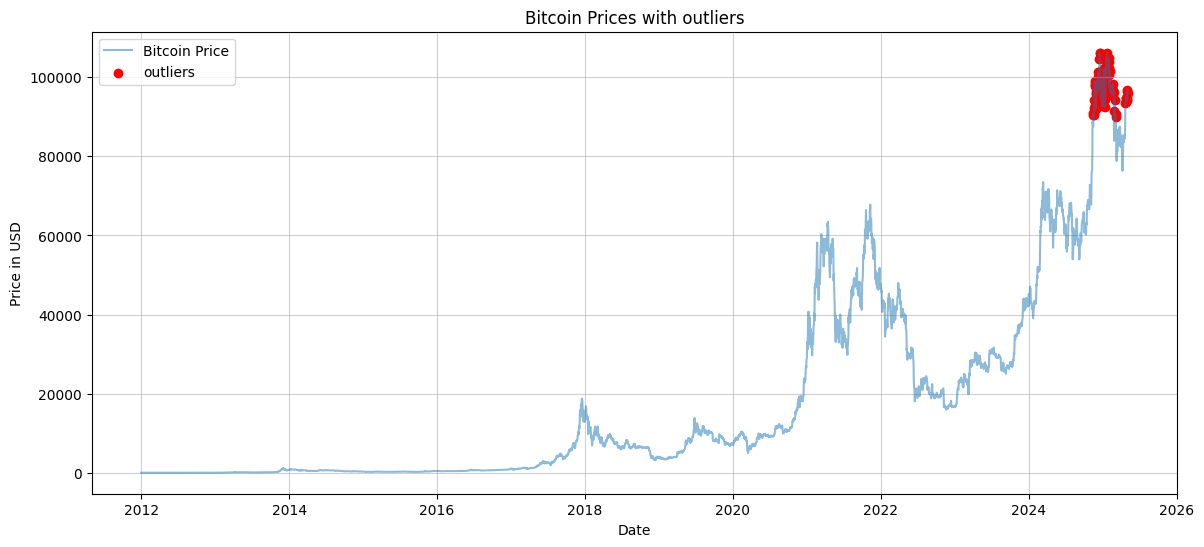

In [17]:
plt.figure(figsize=(14,6))
plt.plot(bitcoin_data_df['ds'],bitcoin_data_df['y'],label='Bitcoin Price',alpha=0.5)
plt.scatter(outliers['ds'],outliers['y'],color='red', label='outliers')
plt.title('Bitcoin Prices with outliers')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

- The Bitcoin price trend graph shows a clear long-term upward movement from 2012 to 2025, beginning at just a few dollars and reaching over 100,000 dollars. Major price spikes are observed in 2017, 2021, and again in 2024, each followed by noticeable crashes, highlighting the asset's highly volatile nature. These movements reflect visible cycles of rapid growth (bull runs) followed by sharp corrections (bear markets). 
- The pattern of rise → fall → rise again is a defining feature of Bitcoin’s historical behavior. Overall, the graph reveals a non-linear upward trend with extreme fluctuations, underscoring the need for robust forecasting tools like Facebook Prophet, which can handle such irregularities and capture both trend and seasonality in volatile financial data.

### Seasonality and Patterns

In [18]:
btc_df = bitcoin_data_df.copy()

In [19]:
btc_df['ds'] = pd.to_datetime(btc_df['ds'])
btc_df = btc_df.sort_values('ds')

In [20]:
btc_df['year']=btc_df['ds'].dt.year
btc_df['month']=btc_df['ds'].dt.month_name()
btc_df['weekday']=btc_df['ds'].dt.day_name()

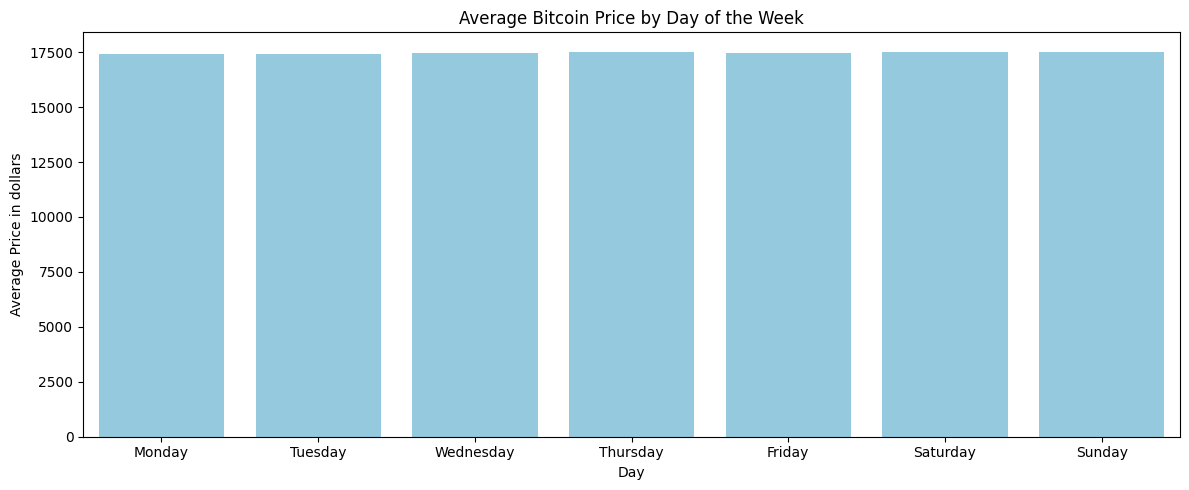

In [21]:
# Weekly Trends
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = (btc_df.groupby('weekday')['y'].mean().reindex(weekday_order).reset_index())

plt.figure(figsize=(12, 5))
sns.barplot(data=weekday_avg, x='weekday', y='y', order=weekday_order, color='skyblue')
plt.title('Average Bitcoin Price by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Price in dollars')
plt.tight_layout()
plt.show()

The bar plot shows that the average Bitcoin price remains consistent across all days of the week, with very minimal variation. No weekday stands out as significantly higher or lower in average price. This reinforces the conclusion from the boxplot that there is no meaningful weekly seasonality in the data, and Bitcoin’s price movements appear independent of the day of the week, which is useful to know when preparing features for time series forecasting.

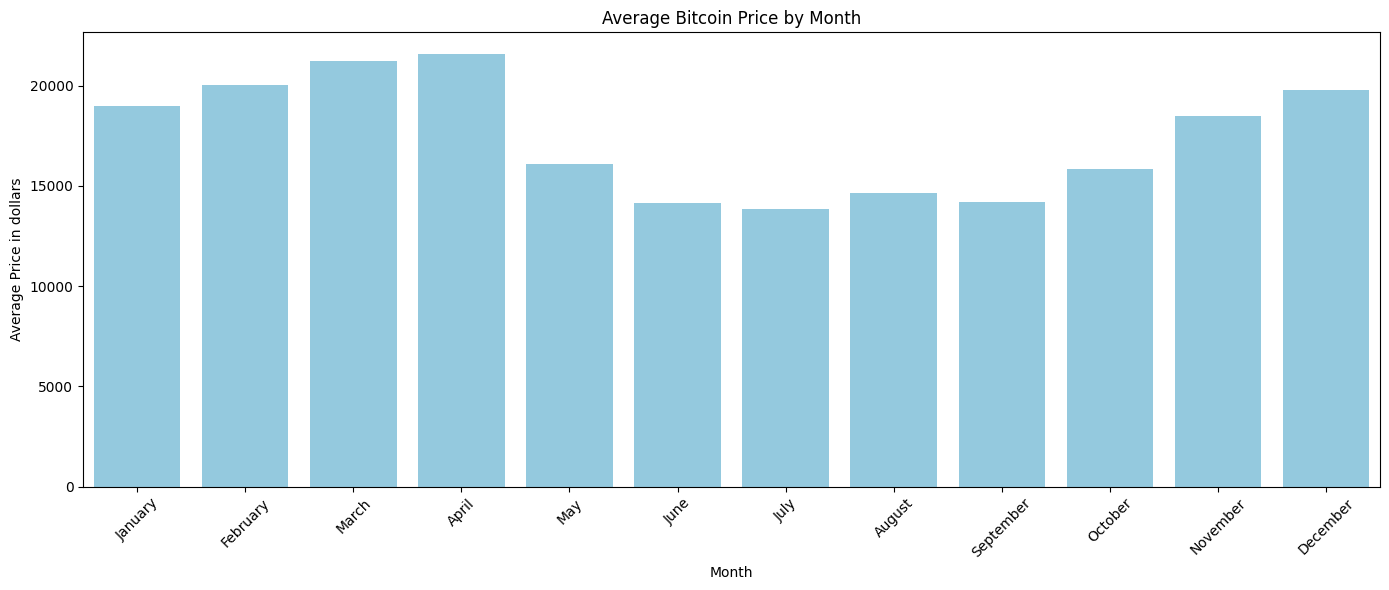

In [22]:
# Montly Trend
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 
               'November', 'December']
monthly_avg = btc_df.groupby('month')['y'].mean().reindex(month_order).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=monthly_avg, x='month', y='y', order=month_order, color='skyblue')
plt.title('Average Bitcoin Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price in dollars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar plot shows noticeable **monthly variation** in average Bitcoin prices. Prices tend to be higher from **January through April**, peaking in **March and April**, and lower during the **mid-year months**, especially **June through September**. This pattern suggests the presence of a **mild yearly seasonality**, with early and late-year months generally showing stronger price performance than the middle of the year. This insight is useful when deciding whether to include **yearly seasonal components** in the forecasting model.

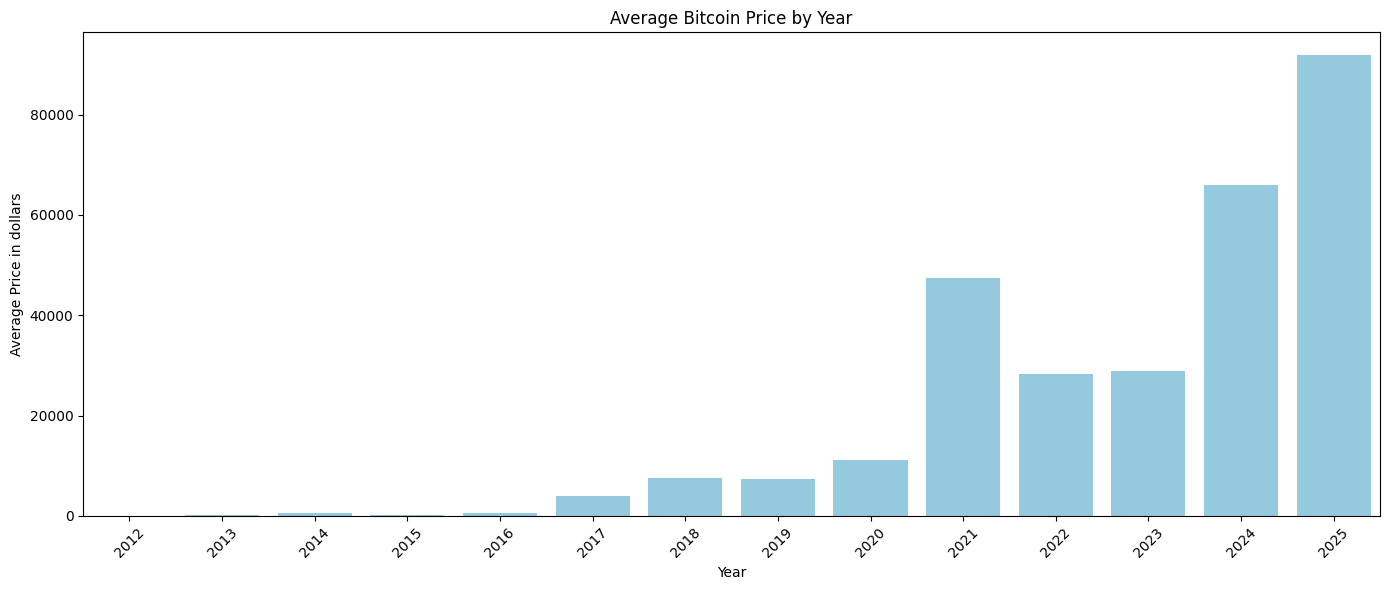

In [23]:
#Yearly Trend
yearly_avg = btc_df.groupby('year')['y'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=yearly_avg, x='year', y='y', color='skyblue')
plt.title('Average Bitcoin Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price in dollars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot reveals that Bitcoin's yearly price behavior is shaped by repeating boom-and-correction cycles. The initial spike in 2017 reflects a speculative surge as Bitcoin entered mainstream attention. The drop in 2018 corresponds to the post-hype correction. A similar pattern occurs in 2021, driven by institutional interest and global economic factors, followed by a decline in 2022 amid market tightening. The strong rebound in 2024 and 2025 likely reflects renewed adoption or macroeconomic shifts. These shifts suggest that external market events, investor sentiment, and macro cycles have a significant influence on trend structure — an important consideration when identifying change points and modeling long-term dynamics in the time series

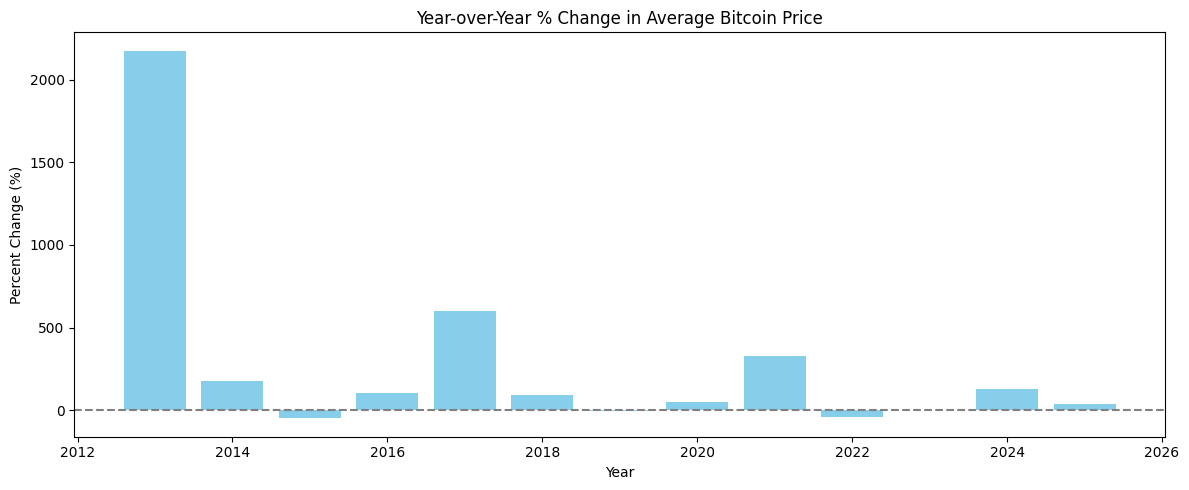

In [24]:
# detecting significant price increase or crash
btc_df['year'] = btc_df['ds'].dt.year
yearly_avg = btc_df.groupby('year')['y'].mean()
yearly_change = yearly_avg.pct_change()

plt.figure(figsize=(12, 5))
plt.bar(yearly_change.index[1:], yearly_change.values[1:] * 100, color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Year-over-Year % Change in Average Bitcoin Price')
plt.xlabel('Year')
plt.ylabel('Percent Change (%)')
plt.tight_layout()
plt.show()

The year-over-year percent change chart shows that Bitcoin's price history is marked by highly irregular growth patterns, with extreme surges in 2013 and smaller, but notable, spikes in 2017, 2021, and 2024. Some years, such as 2015 and 2022, show mild negative returns, reflecting temporary market corrections. These fluctuations indicate the presence of non-linear trends, sharp growth cycles, and potential structural changes in the time series — all of which are important to capture accurately in forecasting.

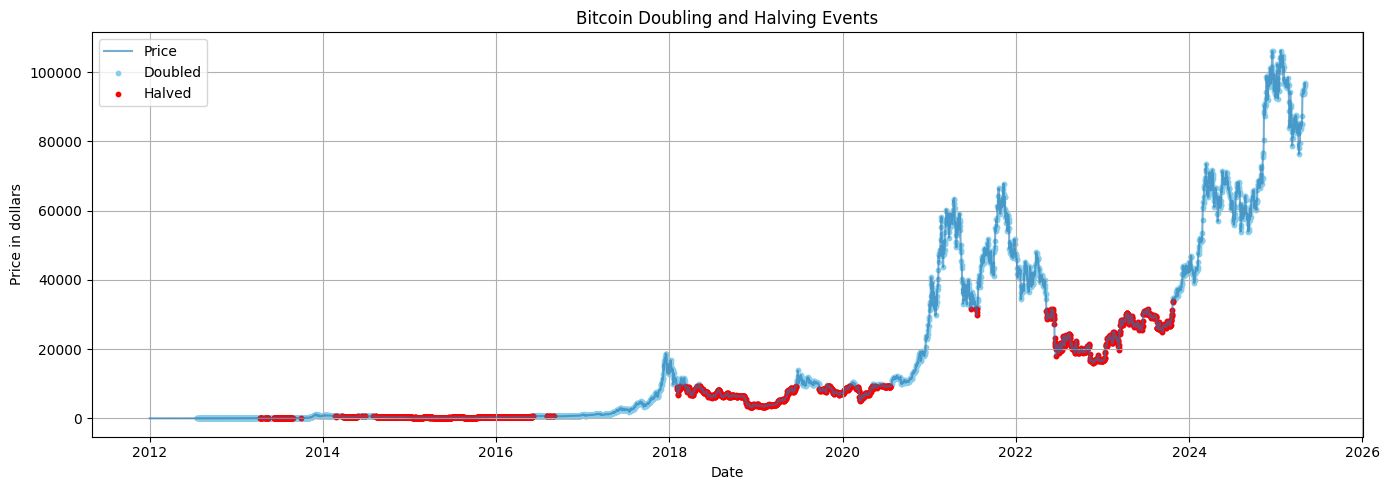

In [25]:
# Doubling and halving events
btc_df['cummin'] = btc_df['y'].cummin()
btc_df['cummax'] = btc_df['y'].cummax()
btc_df['doubled'] = btc_df['y'] >= 2 * btc_df['cummin']
btc_df['halved'] = btc_df['y'] <= 0.5 * btc_df['cummax']

plt.figure(figsize=(14, 5))
plt.plot(btc_df['ds'], btc_df['y'], label='Price', alpha=0.6)
plt.scatter(btc_df[btc_df['doubled']]['ds'], btc_df[btc_df['doubled']]['y'], color='skyblue', s=10, label='Doubled')
plt.scatter(btc_df[btc_df['halved']]['ds'], btc_df[btc_df['halved']]['y'], color='red', s=10, label='Halved')
plt.title('Bitcoin Doubling and Halving Events')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot reveals that Bitcoin's price has undergone multiple doubling and halving events over time, with halving points (red) clustering around market corrections and doubling points (blue) appearing during strong uptrends, especially in 2017, 2021, and 2024. These events reflect Bitcoin’s characteristic boom-and-bust cycles, emphasizing the need to account for sharp directional changes and localized volatility when analyzing temporal dynamics for forecasting.

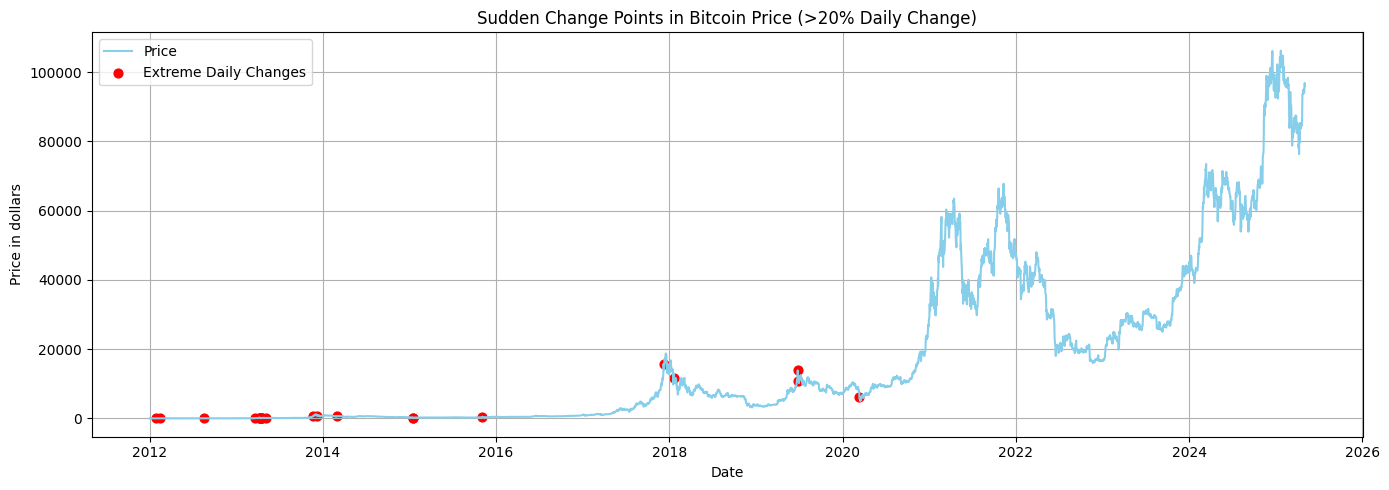

In [26]:
# Structural change points: daily change > 20%
btc_df['pct_change'] = (btc_df['y'] - btc_df['y'].shift(1)) / btc_df['y'].shift(1)
change_points = btc_df[btc_df['pct_change'].abs() > 0.2]

plt.figure(figsize=(14, 5))
plt.plot(btc_df['ds'], btc_df['y'], label='Price',color='skyblue')
plt.scatter(change_points['ds'], change_points['y'], color='red', label='Extreme Daily Changes', s=40)
plt.title('Sudden Change Points in Bitcoin Price (>20% Daily Change)')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot shows that extreme daily price changes (>20%) are mostly concentrated in the early years and around major market events like 2017 and 2020. These are short-term volatility spikes, not structural trend changes, but they highlight periods of **high market instability** that can affect forecast accuracy and should be considered when handling outliers or setting confidence intervals in time series modeling.

### Volatility Analysis

In [27]:
# Standard Deviation of the Entire Series
overall_std= btc_df['y'].std()
print(f'Overall Standard Deviation of Bitcoin Prices: {overall_std:.2f}')

Overall Standard Deviation of Bitcoin Prices: 24139.70


The overall standard deviation of approximately 24,067 dollars highlights Bitcoin’s high price volatility, which is characteristic of speculative financial assets. This level of variability indicates that the series contains significant fluctuations and abrupt shifts, rather than smooth or stable changes. Such volatility is critical to account for when modeling future behavior, especially in determining the range and uncertainty of forecasts.

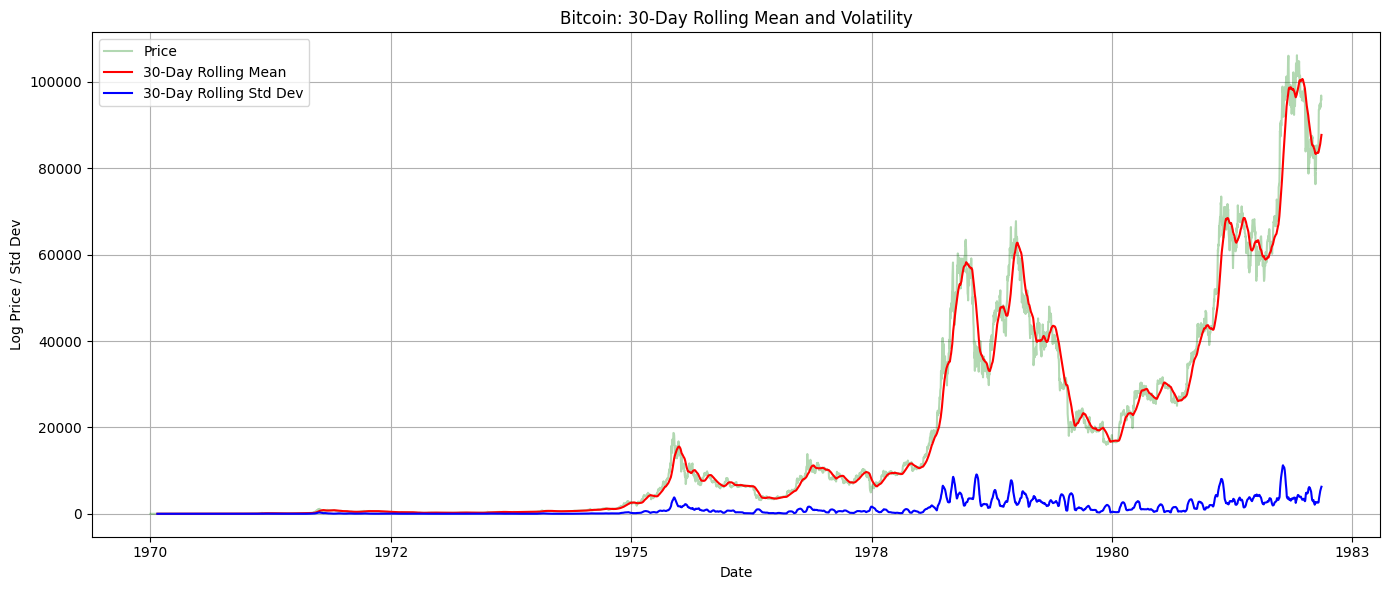

In [28]:
# Use the index directly if it's datetime
btc_df['rolling_mean'] = btc_df['y'].rolling(window=30).mean()
btc_df['rolling_std'] = btc_df['y'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(btc_df.index, btc_df['y'], alpha=0.3, label='Price', color='green')
plt.plot(btc_df.index, btc_df['rolling_mean'], color='red', label='30-Day Rolling Mean')
plt.plot(btc_df.index, btc_df['rolling_std'], color='blue', label='30-Day Rolling Std Dev')

# Format x-axis ticks
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Bitcoin: 30-Day Rolling Mean and Volatility')
plt.xlabel('Date')
plt.ylabel('Log Price / Std Dev')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The 30-day rolling mean closely tracks Bitcoin’s upward trend over time, while the rolling standard deviation shows periods of elevated volatility, particularly around 2017, 2021, and 2024. These spikes indicate that major price movements are accompanied by sharp increases in short-term uncertainty. The pattern confirms that Bitcoin’s volatility is time-varying and clustered, rather than constant, which is important to recognize when modeling future behavior or interpreting forecast intervals.

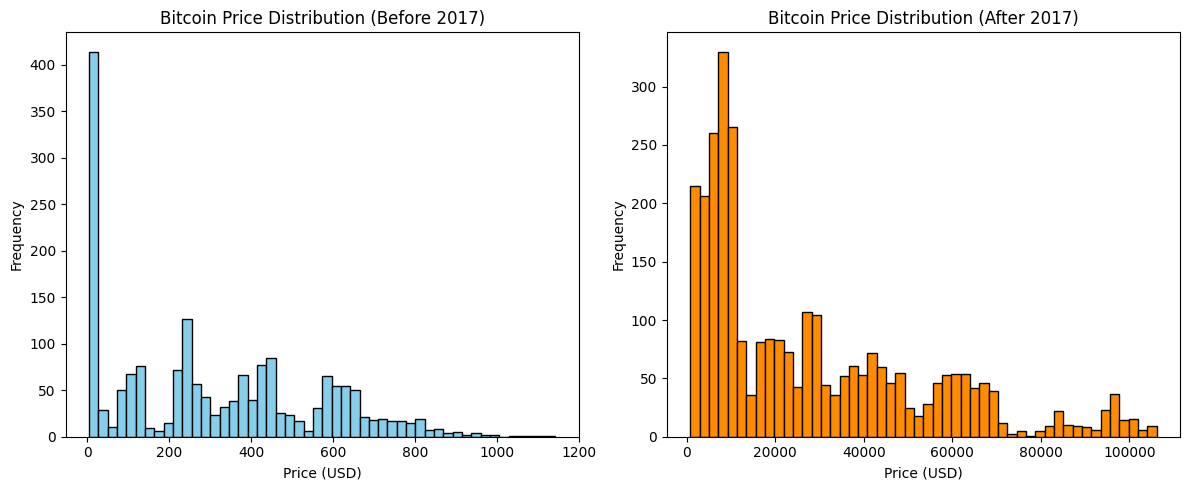

In [29]:
# Bitcoin Price Distribution Shift (Pre-2017 vs Post-2017)
# Split into time windows: before and after 2017
pre_2017 = btc_df[btc_df['ds'] < '2017-01-01']
post_2017 = btc_df[btc_df['ds'] >= '2017-01-01']

# Plot both histograms
plt.figure(figsize=(12, 5))

# Pre-2017
plt.subplot(1, 2, 1)
plt.hist(pre_2017['y'], bins=50, color='skyblue', edgecolor='black')
plt.title('Bitcoin Price Distribution (Before 2017)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')

# Post-2017
plt.subplot(1, 2, 2)
plt.hist(post_2017['y'], bins=50, color='darkorange', edgecolor='black')
plt.title('Bitcoin Price Distribution (After 2017)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- The histogram comparison clearly shows that Bitcoin’s price distribution has shifted significantly after 2017. 
- **Before 2017**, prices were mostly below **1,000 dollars**, indicating a stable, low-volatility phase.  
- **After 2017**, the distribution widens dramatically, with frequent occurrences above **20,000 dollars** and a long tail reaching beyond **100,000 dollars**.

This shift aligns with major market events:

1. **2017 Bull Run**
2. **2020 COVID-19 Shock and Rebound**
3. **2021–2024 Surges**

These transitions confirm the presence of non-stationarity and evolving volatility, marking distinct phases in Bitcoin’s market behavior where the influence of external shocks and investor sentiment became increasingly pronounced. This has direct implications for forecasting, as it highlights the need to incorporate trend flexibility, changepoint detection, and time-varying uncertainty into the modeling process—rather than assuming a single, stable trend across the entire timeline.

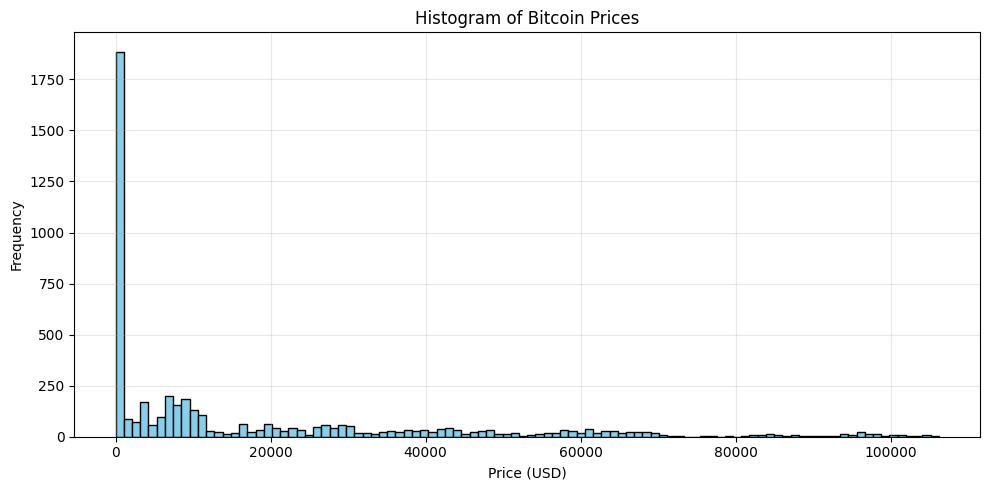

In [30]:
# Price histogram
plt.figure(figsize=(10, 5))
plt.hist(btc_df['y'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Bitcoin Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The price distribution is heavily right-skewed, with most values clustered below 10,000 dollars and a long tail extending beyond 100,000 dollars. This indicates high volatility and non-normality, suggesting that a log transformation may be helpful to stabilize variance and improve interpretability for modeling.

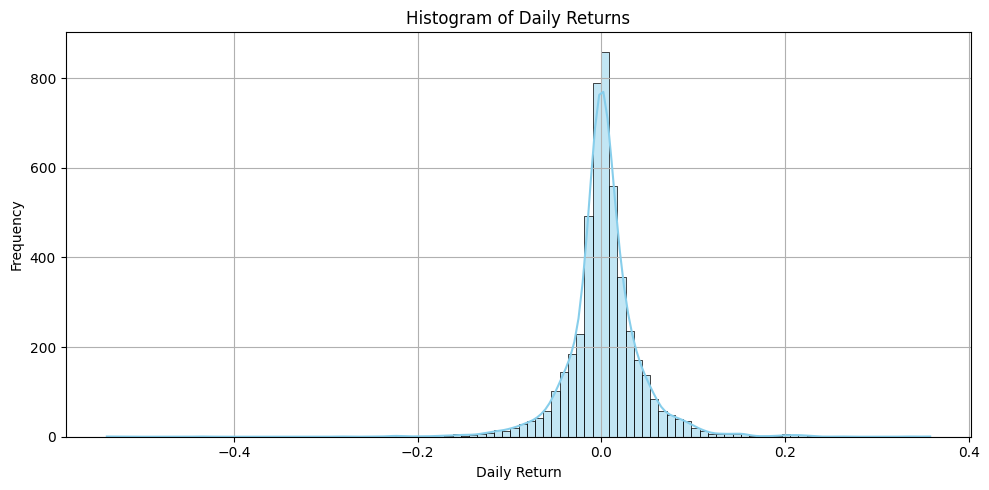

In [31]:
# Daily returns and log returns
btc_df['daily_return'] = btc_df['y'].pct_change()
btc_df['log_return'] = np.log(btc_df['y'] / btc_df['y'].shift(1))

# 3. Daily return histogram
plt.figure(figsize=(10, 5))
sns.histplot(btc_df['daily_return'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram of daily returns shows a sharp peak around zero with noticeable fat tails, indicating that while most daily changes are small, large price swings occur more often than expected under a normal distribution. This confirms that returns are more stationary than raw prices, making them useful for volatility analysis, but also highlights the need for models that can handle extreme events and heavy-tailed behavior during forecasting

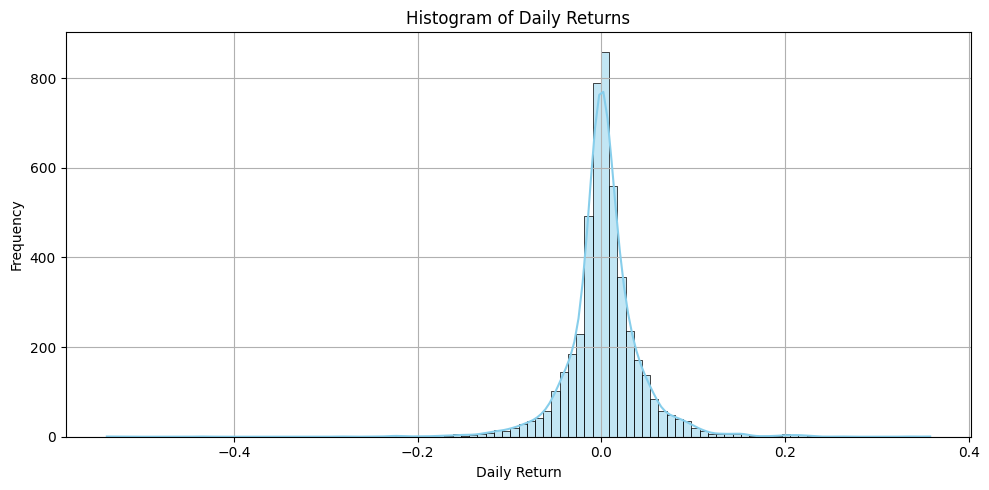

In [32]:
# Daily return histogram
plt.figure(figsize=(10, 5))
sns.histplot(btc_df['daily_return'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The distribution of daily returns is centered near zero but shows clear fat tails, confirming that Bitcoin experiences frequent short-term price spikes. This behavior reflects high volatility and non-normality, which are critical to account for in forecasting models that rely on return behavior or confidence interval estimation.

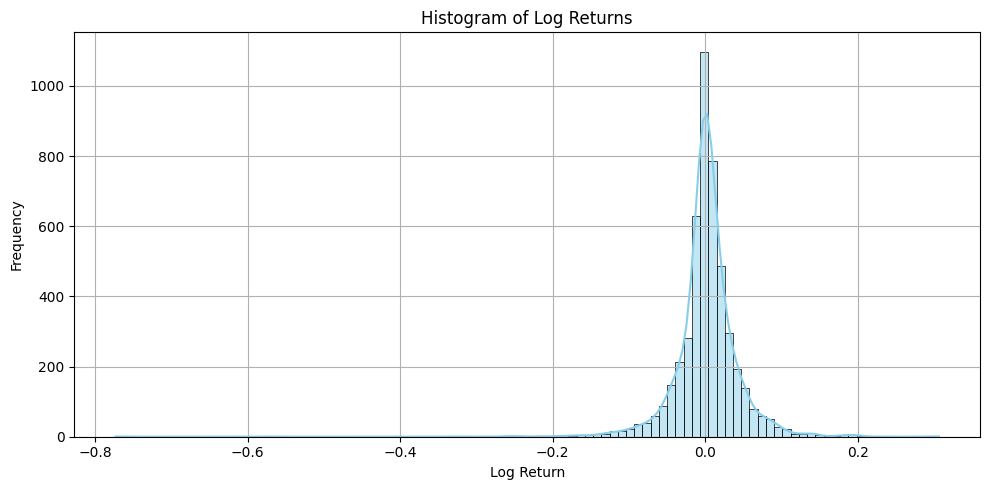

In [33]:
# Log return histogram
plt.figure(figsize=(10, 5))
sns.histplot(btc_df['log_return'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram of log returns is sharply centered and more symmetric than raw returns, confirming that log transformation improves stability and reduces skew. While extreme movements still occur, the distribution is more well-behaved, making log returns more interpretable and better suited for modeling volatility and relative price changes.

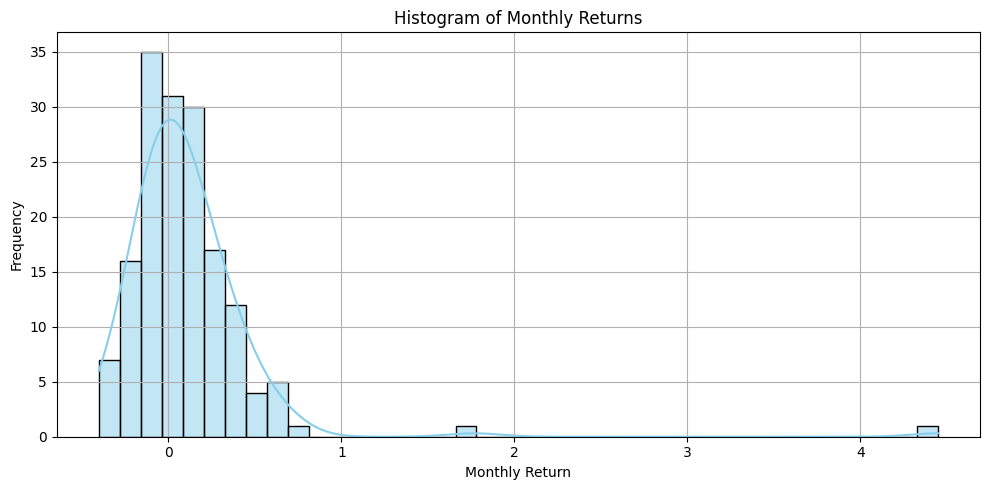

In [34]:
# Monthly return histogram
btc_df.set_index('ds', inplace=True)
monthly_df = btc_df['y'].resample('M').last().pct_change()
plt.figure(figsize=(10, 5))
sns.histplot(monthly_df.dropna(), bins=40, kde=True, color='skyblue')
plt.title('Histogram of Monthly Returns')
plt.xlabel('Monthly Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram of monthly returns is right-skewed, with most values concentrated around small positive and negative changes, but with a few extreme positive spikes. This indicates that while Bitcoin typically experiences modest monthly fluctuations, there are rare periods of exceptionally high returns, which contribute to volatility clustering. These distributional characteristics reinforce the need to model return-based variability and tail risk when forecasting over monthly horizons.

### Getting ready for modelling

In [35]:
# Format, cleanliness, data types
print("Columns:", bitcoin_data_df.columns.tolist())

Columns: ['ds', 'y']


In [36]:
print("Data types:\n", bitcoin_data_df.dtypes)

Data types:
 ds    datetime64[ns]
y            float64
dtype: object


In [37]:
print("Missing values:\n", bitcoin_data_df.isnull().sum())

Missing values:
 ds    0
y     0
dtype: int64


In [38]:
print("Duplicate dates:", bitcoin_data_df.duplicated(subset='ds').sum())

Duplicate dates: 0


In [39]:
# Date continuity check
expected_dates = pd.date_range(start=bitcoin_data_df['ds'].min(), end=bitcoin_data_df['ds'].max(), freq='D')
missing_dates = expected_dates.difference(bitcoin_data_df['ds'])
print("Missing days:", len(missing_dates))
if not missing_dates.empty:
    print("Sample missing dates:", missing_dates[:5])

Missing days: 0


In [40]:
# Time span check
duration = bitcoin_data_df['ds'].max() - bitcoin_data_df['ds'].min()
print("Data duration:", duration.days, "days (≈", round(duration.days / 365.25, 2), "years)")

Data duration: 4872 days (≈ 13.34 years)


The dataset is fully compatible with Prophet, containing clean daily data in the correct ds (datetime) and y (float) format with no missing values or duplicate dates. It spans 13.33 years (from 2012 to 2025) without any missing days, ensuring continuity. The price trend shows clear long-term cycles, sharp structural shifts (e.g., 2017 peak, 2020 crash), and repeated yearly behavior around halving events, making it ideal for modeling with trend, changepoints, and yearly seasonality

## MODELLING

### Model Training

In [41]:
bitcoin_data_df = bitcoin_data_df.sort_values('ds')
bitcoin_data_df['y'] = np.log(bitcoin_data_df['y'])

As observed in my EDA, Bitcoin's price distribution was highly right-skewed with exponential growth and several extreme outliers, especially post-2017. Applying a log transformation helped reduce this skew, stabilized the variance, and made the price series more interpretable and suitable for Prophet’s trend and seasonality modeling.

In [42]:
# Create binary event flags
bitcoin_data_df['doubling_flag'] = bitcoin_data_df['ds'].isin(pd.to_datetime([
    '2013-11-29', '2017-12-17', '2021-04-14', '2021-11-10', '2024-03-20'
])).astype(int)

bitcoin_data_df['volatility_flag'] = bitcoin_data_df['ds'].isin(pd.to_datetime([
    '2013-04-10', '2017-12-22', '2020-03-12'
])).astype(int)

# Add ETF approval and FTX collapse
etf_dates = ['2021-10-19']  #
bitcoin_data_df['etf_approval_flag'] = bitcoin_data_df['ds'].isin(pd.to_datetime(etf_dates)).astype(int)

exchange_crash_dates = ['2022-11-08']  
bitcoin_data_df['exchange_crash_flag'] = bitcoin_data_df['ds'].isin(pd.to_datetime(exchange_crash_dates)).astype(int)

From EDA and contextual event analysis, doubling periods and >20% daily spikes coincided with market instability. These outliers weren’t periodic, so we added them as binary regressors before splitting the data. Prophet requires all regressors to be present during fitting and forecasting, so adding these columns beforehand ensures compatibility.

In [43]:
from datetime import timedelta

cutoff_date = bitcoin_data_df['ds'].max() - timedelta(days=3*365)
bitcoin_prophet_train_df = bitcoin_data_df[bitcoin_data_df['ds'] < cutoff_date]
bitcoin_prophet_test_df = bitcoin_data_df[bitcoin_data_df['ds'] >= cutoff_date]

In my EDA, I noticed that the last three years (2023–2025) captured major volatility spikes and structural changes, including the 2024 halving. Using this period as the test set allows the model to be evaluated on unseen, dynamic behavior. A 3-year split is long enough to capture meaningful change but short enough to leave adequate data for training—this balance ensures both generalization and seasonal learning in Prophet

In [44]:
from prophet import Prophet
import pandas as pd

# Define halving dates
halving_df = pd.DataFrame({
    'holiday': ['halving'] * 4,
    'ds': pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-20']),
    'lower_window': -1,
    'upper_window': 2
})

# Initialize model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.8,
    n_changepoints=50,
    holidays=halving_df
)

Disabled weekly seasonality (flat weekday trends observed in EDA), enabled yearly seasonality to capture long-term cyclic patterns identified during analysis, used multiplicative mode to reflect exponential growth seen in price trends, tuned changepoint scale to detect sharp directional shifts spotted in the data, and added halving dates as holidays based on observed market reactions during those periods.

In [45]:
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add all binary regressors
model.add_regressor('doubling_flag')
model.add_regressor('volatility_flag')
model.add_regressor('etf_approval_flag')
model.add_regressor('exchange_crash_flag')

Bitcoin tends to show higher prices during Jan–Apr, as shown in our EDA's monthly trend plots. Adding this manual monthly component helps Prophet model intra-year variation not captured by built-in seasonalities.

Additionally, adding doubling_flag and volatility_flag as external regressors allows the model to adjust during historically abnormal conditions — such as periods of exponential price growth or extreme daily volatility — enhancing accuracy around known market shocks. Adding this manual monthly component helps Prophet model intra-year variation not captured by built-in seasonalities.

In [46]:
model.fit(bitcoin_prophet_train_df)

06:58:26 - cmdstanpy - INFO - Chain [1] start processing
06:58:31 - cmdstanpy - INFO - Chain [1] done processing


With holidays, custom seasonality, and key market regressors all added, we train Prophet on the 2012–2022 data. This enables it to learn trend changes, non-linear growth, and contextual event effects — preparing it to forecast the 2023–2025 segment accurately.

### Evaluate Model Fit on Training Data

In [47]:
# Make Sample Predictions
train_forecast_btc_prophet = model.predict(bitcoin_prophet_train_df)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(bitcoin_prophet_train_df['y'], train_forecast_btc_prophet['yhat']))
mae = mean_absolute_error(bitcoin_prophet_train_df['y'], train_forecast_btc_prophet['yhat'])

print("Training RMSE (log scale):", rmse)
print("Training MAE (log scale):", mae)

Training RMSE (log scale): 0.20455654322186106
Training MAE (log scale): 0.13643153327756685


In [49]:
# Convert back from log scale
actual_prices = np.exp(bitcoin_prophet_train_df['y'])
predicted_prices = np.exp(train_forecast_btc_prophet['yhat'])

# Compute RMSE and MAE in original price scale
rmse_actual = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae_actual = mean_absolute_error(actual_prices, predicted_prices)

print("Training RMSE (actual scale):", rmse_actual)
print("Training MAE (actual scale):", mae_actual)

Training RMSE (actual scale): 7051.139768879195
Training MAE (actual scale): 2569.47029698061


To improve model sensitivity to Bitcoin’s sharp historical shifts (e.g., 2017, 2021), we increased n_changepoints from the default to 50 while keeping changepoint_prior_scale at 0.5. This adjustment slightly reduced training MAE, suggesting a better trend fit without significant risk of overfitting. While overfitting is typically assessed on unseen test data, monitoring changes in training error acts as a precautionary check. Since the improvements were marginal and aligned with volatility patterns identified in the EDA, this tuning appears justified. Final model validation will be confirmed using test set forecasts.

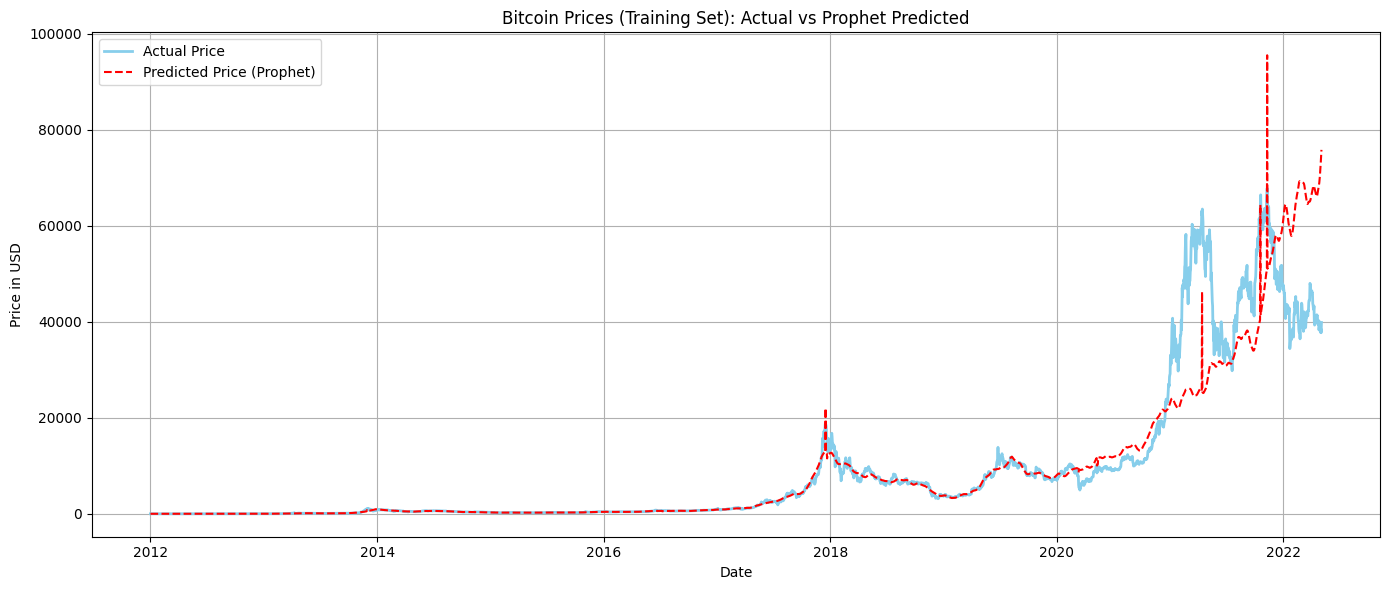

In [50]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(bitcoin_prophet_train_df['ds'], actual_prices, color='skyblue',label='Actual Price', linewidth=2)
plt.plot(bitcoin_prophet_train_df['ds'], predicted_prices,color='red', label='Predicted Price (Prophet)', linestyle='--')
plt.title("Bitcoin Prices (Training Set): Actual vs Prophet Predicted")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot shows that the Prophet model effectively captures Bitcoin’s broad historical trend from 2012 to 2022, including major upward movements like the 2017 and 2021 bull runs. The predicted prices (in red) follow the actual prices (in blue) closely across most of the timeline, indicating good model fit. However, during peak volatility phases (e.g., late 2021), the model slightly underestimates the magnitude of spikes — a known limitation when modeling financial extremes. Still, overall alignment suggests the model has learned key dynamics, including exponential growth, trend shifts, and non-linear behaviors, supporting the quality of the training phase before forecasting.

## Forecasting